**Name:** Don Price<br>
**Assignment:** Final Project - Milestone 5<br>
**Class:** DSC 540

In [1]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3
from sqlalchemy import create_engine

### Import Datafiles Constructed in Milestones 1-4
See 'DataProcessing' notebooks for details on data sources, download processes, and data processing. These sources will be ingested into our SQL database for analysis.

In [2]:
# Identify files.

POLICYFILE = 'tx_policy_df.csv'
CLAIMSFILE = 'tx_claims_df.csv'
EXPOSUREFILE = 'housing_df.csv'

# Load csv files to dataframes.

policy_df = pd.read_csv(POLICYFILE, index_col=0, dtype={'County_Code': str})
claims_df = pd.read_csv(CLAIMSFILE, dtype={'countyCode': str})
exposure_df = pd.read_csv(EXPOSUREFILE, index_col=0, dtype={'FIPS': str})

In [3]:
# Verify policy df loaded properly.
print(f'Shape: {policy_df.shape}')

Shape: (912, 8)


In [4]:
policy_df.head()

,County_Code,Policy_Effective_Year,Total_Policy_Insurance_Cost,Units_Per_Policy,Building_Limits_Purchased,Contents_Limits_Purchased,Policy_Insurance_Premium,Policy_Sold_Count
0,NaN,2018,1042.370764,2031.0,4.015018e+08,139701200.0,775.486596,1977
1,NaN,2019,982.291101,2713.0,5.652844e+08,200235000.0,734.388009,2652
2,NaN,2020,770.583605,5575.0,1.234325e+09,466689300.0,567.490569,5514
3,NaN,2021,807.950755,1547.0,3.460735e+08,121923900.0,594.995404,1523
4,22019,2018,591.000000,1.0,1.250000e+05,50000.0,275.000000,1


In [5]:
# Verify claims df loaded properly.
print(f'Shape: {claims_df.shape}')

Shape: (391291, 34)


In [6]:
claims_df.head()

,agricultureStructureIndicator,asOfDate,condominiumIndicator,policyCount,countyCode,communityRatingSystemDiscount,dateOfLoss,elevatedBuildingIndicator,censusTract,floodZone,...,postFIRMConstructionIndicator,rateMethod,smallBusinessIndicatorBuilding,state,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,yearOfLoss,reportedZipcode,primaryResidence,Total_Loss
0,0.0,2021-11-21 00:34:48.052000+00:00,N,1.0,48201.0,5.0,2001-06-09 04:00:00+00:00,0.0,4.820141e+10,AE,...,1.0,1,0.0,TX,25000.0,25000.0,2001,77025.0,1.0,0.00
1,0.0,2021-07-25 01:39:04.381000+00:00,N,1.0,48201.0,7.0,2006-06-19 04:00:00+00:00,0.0,4.820123e+10,X,...,1.0,7,0.0,TX,150000.0,60000.0,2006,77015.0,1.0,0.00
2,0.0,2021-07-25 01:39:04.381000+00:00,N,1.0,48439.0,8.0,1992-06-28 04:00:00+00:00,0.0,4.843911e+10,X,...,0.0,7,0.0,TX,20000.0,5000.0,1992,76112.0,0.0,355.03
3,0.0,2021-11-21 00:34:48.052000+00:00,N,1.0,48201.0,7.0,2008-09-12 04:00:00+00:00,0.0,4.820125e+10,X,...,1.0,7,0.0,TX,125000.0,50000.0,2008,77346.0,1.0,0.00
4,0.0,2021-12-11 23:44:01.395000+00:00,N,1.0,48201.0,6.0,1998-01-21 05:00:00+00:00,0.0,4.820125e+10,X,...,0.0,1,0.0,TX,126800.0,26900.0,1998,77521.0,1.0,4401.81


In [7]:
# Remove ".0" from countyCode

claims_df['countyCode'] = claims_df['countyCode'].str.replace('\.0','', regex=True)

In [8]:
# Verify exposure df loaded properly
print(f'Shape: {exposure_df.shape}')

Shape: (470, 4)


In [9]:
exposure_df.head()

,County,Housing_Counts,State,FIPS
0,Adams,30278,IL,17001
1,Alexander,3977,IL,17003
2,Bond,7286,IL,17005
3,Boone,20097,IL,17007
4,Brown,2451,IL,17009


### Construct SQL Database with 3 Tables

In [10]:
# Create SQL database engine.
engine = create_engine('sqlite:///price_540project', echo=False)

In [11]:
# Convert 3 dataframes to SQL tables in the price_540project database.

policy_df.to_sql(name='policy_table', con=engine, if_exists='replace')
claims_df.to_sql(name='claims_table', con=engine, if_exists='replace')
exposure_df.to_sql(name='exposure_table', con=engine, if_exists='replace')

### Connect to SQL Database

In [12]:
# Create connection to "pets.db"

conn = sqlite3.connect("price_540project")

# Create cursor

cursor = conn.cursor()

In [13]:
# Verify whether connection worked.

try:
    cursor.execute('SELECT * FROM policy_table')
    print('Connection successful.')
except:
    print('Connection failed.')

Connection successful.


### Construct Consolidated Query

**Procedures:**
The claims data is available for all years, dating back to 1978. The claims data is specific to TX (filtered in prior milestones). Claims data includes insurance coverage, characteristics of homes, and details of the limits purchased. Data is aggregated by county and year.

Policy data is appended to the claims data set. Less history is available for policy years, so we will join the policy table to the claims table using a left join. The join will include both the policy year and county. Policy counts and premiums will be used for this analysis.

Lastly, the exposure data - 2018 number of households by county - will be used to assess total risk and concentration of risk. This data is being left joined to our claims data set using county code.

In [14]:
consolidated = cursor.execute('''SELECT cl.countyCode,
                                        cl.yearOfLoss AS Loss_Year,
                                        sum(cl.Total_Loss),
                                        sum(cl.totalBuildingInsuranceCoverage),
                                        sum(cl.totalContentsInsuranceCoverage),
                                        sum(cl.amountPaidOnBuildingClaim),
                                        sum(cl.amountPaidOnContentsClaim),
                                        sum(pol.Policy_Sold_Count) AS Policies_Sold, 
                                        sum(pol.Policy_Insurance_Premium) AS Policy_Premium,
                                        exp.County,
                                        exp.Housing_Counts
                                 FROM claims_table cl
                                 LEFT JOIN policy_table pol ON (pol.County_Code=cl.countyCode AND
                                                                pol.Policy_Effective_Year=cl.yearOfLoss)
                                 LEFT JOIN exposure_table exp ON exp.FIPS=cl.countyCode
                                 GROUP BY cl.countyCode, cl.yearOfLoss
                              ''')

In [15]:
cons_cols = ['County_Code', 'Year_Loss', 'Total_Loss_Amt', 'Building_Coverage_Amt', 'Contents_Coverage_Amt',
             'Building_Loss_Amt', 'Contents_Loss_Amt', 'Policy_Sold_Count', 'Policy_Premiums', 'County_Name',
             'Housing_Counts']

cons_df = pd.DataFrame(consolidated, columns=cons_cols)

In [16]:
# Verify dataframe built properly.

cons_df.head()

,County_Code,Year_Loss,Total_Loss_Amt,Building_Coverage_Amt,Contents_Coverage_Amt,Building_Loss_Amt,Contents_Loss_Amt,Policy_Sold_Count,Policy_Premiums,County_Name,Housing_Counts
0,None,1978,48750.05,233100.0,133000.0,45324.74,3425.31,NaN,NaN,None,NaN
1,None,1979,2275483.02,9338200.0,2080100.0,1850349.19,425133.83,NaN,NaN,None,NaN
2,None,1980,949587.16,7309400.0,1720900.0,655491.88,294095.28,NaN,NaN,None,NaN
3,None,1981,749451.57,5014200.0,1118200.0,586521.63,162929.94,NaN,NaN,None,NaN
4,None,1982,318896.28,1663300.0,532700.0,237161.35,81734.93,NaN,NaN,None,NaN


In [17]:
# Verify dataframe shape.

cons_df.shape

(4085, 11)

In [18]:
# Check Nulls. 
# The nulls are expected. There is not policy data or housing counts data for several years in our claims data,
# which dates back to 1978. Some blank counties also date to older years in the claims data, which will not affect
# the analysis.

cons_df.isnull().sum()

County_Code                42
Year_Loss                   0
Total_Loss_Amt              0
Building_Coverage_Amt       1
Contents_Coverage_Amt       1
Building_Loss_Amt           0
Contents_Loss_Amt           0
Policy_Sold_Count        3701
Policy_Premiums          3701
County_Name               101
Housing_Counts            101
dtype: int64

### Visualizations of Exposure Analysis

In [19]:
# Run a query of exposures, joining the policy and exposure tables.

exposures = cursor.execute('''SELECT pol.County_Code AS County_Code, 
                                     sum(pol.Policy_Sold_Count) AS Policies_Sold, 
                                     sum(pol.Policy_Insurance_Premium) AS Policy_Premium,
                                     exp.County,
                                     exp.Housing_Counts
                              FROM policy_table pol
                              JOIN exposure_table exp ON exp.FIPS=pol.County_Code
                              WHERE pol.Policy_Effective_Year='2018'
                              GROUP BY pol.County_Code
                              ''')

In [20]:
# Convert SQL query to dataframe for graphing.

cols = ['County_Code', 'Policies_Sold', 'Policy_Premium', 'County', 'Housing_Counts']
exp_data = pd.DataFrame(exposures, columns=cols)

In [21]:
# Add Average Premium metric [Policy_Premium / Policies Sold]
exp_data['Avg_Prem'] = exp_data['Policy_Premium'] / exp_data['Policies_Sold']

# Add Policies per Household field
exp_data['Policy_Freq'] = exp_data['Policies_Sold'] / exp_data['Housing_Counts']

#### Graph 1: Percentage of Homes Purchasing Insurance, by County Distribution
Combining the exposure and policy data sets, we can measure how many homes in each county purchased flood insurance. The data shows that in most TX counties, fewer than 5% of homes purchased flood insurance in 2018. There are a small portion of counties where the number of homes that purchase flood exceed 25%. These presumably are coastal areas where hurricances and flood are likely to follow. 

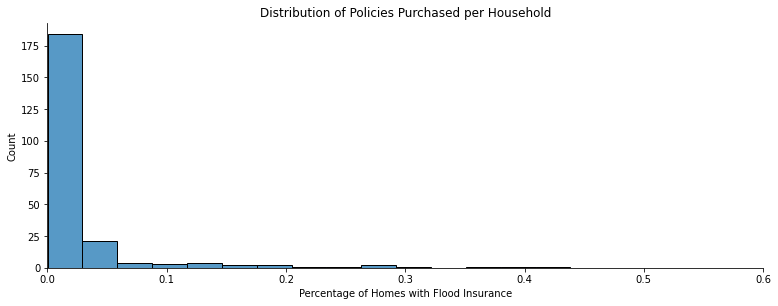

In [22]:
# Prepare a distribution of counties by % of flood policies purchase.
sns.displot(exp_data['Policy_Freq'], bins=15)
plt.title('Distribution of Policies Purchased per Household')
plt.xlabel('Percentage of Homes with Flood Insurance')
plt.xlim([0, 0.6])
plt.gcf().set_size_inches(12,4)

#### Graph 2: Show Top 20 Counties with Flood Coverage
Graph 2 shows the top 20 counties that purchase flood insurance. These counties tend to be eastern coastal counties, so it is expected that these counties purchase flood insurance.

In [23]:
# Filter on top 20 counties in TX with the highest concentration of flood policies purchased per household.
top20 = exp_data.sort_values(by='Policy_Freq', ascending=False).head(20)

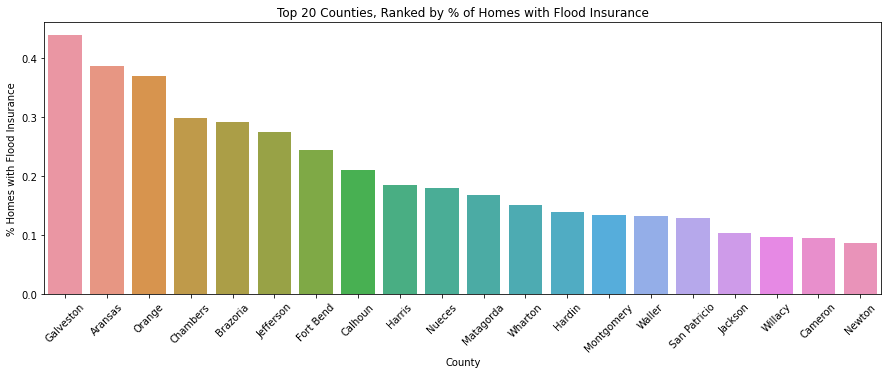

In [24]:
sns.barplot(x='County', y='Policy_Freq', data=top20)
plt.title('Top 20 Counties, Ranked by % of Homes with Flood Insurance')
plt.ylabel('% Homes with Flood Insurance')
plt.xticks(rotation=45)
plt.gcf().set_size_inches(15,5)

#### Graph 3: Graph of Counties with Largest Flood Losses
While correlation is not proven, areas with the largest flood losses since 1978 also have the highest percentage of residents who purchase flood claims. Additional studies would need to be conducted to measure whether flood purchases increase following a disaster, which would be a better indicator of correlation.

Our consolidated data set is used for this report.

In [25]:
# Run a query of all historical claims since 1978. Group losses by county.

county_claims = cons_df.groupby('County_Name', as_index=False)['Total_Loss_Amt'].sum()\
                       .sort_values(by='Total_Loss_Amt', ascending=False)

# Convert Loss $ to Millions
county_claims['Total_Loss_Amt_M'] = county_claims['Total_Loss_Amt']/1000000

# Filter on top 20.
top20claims = county_claims.head(20)

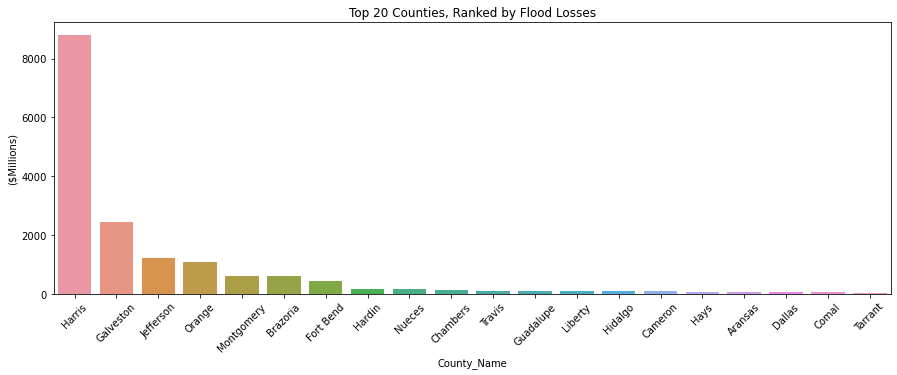

In [26]:
# Graph top 20 counties with claims.

sns.barplot(x='County_Name', y='Total_Loss_Amt_M', data=top20claims)
plt.title('Top 20 Counties, Ranked by Flood Losses')
plt.ylabel('($Millions)')
plt.xticks(rotation=45)
plt.gcf().set_size_inches(15,5)

#### Graph 4: Assess Flood Losses Over Time
The consolidated data set will be used to measure flood losses over time. Flood losses in TX have increased over time with significant flooding events in 2001 (Tropical Storm Allison), 2008 (Hurricane Ike), 2017 (Hurricane Harvey), and 2019.

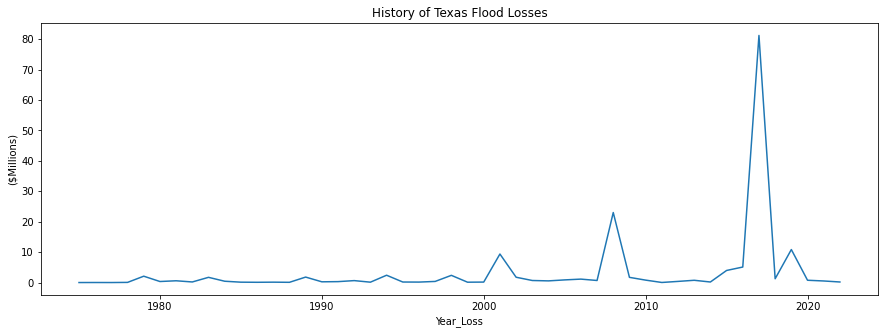

In [27]:
sns.lineplot(data=cons_df, x='Year_Loss', y=cons_df['Total_Loss_Amt']/1000000, ci=None)
plt.title('History of Texas Flood Losses')
plt.ylabel('($Millions)')
plt.gcf().set_size_inches(15,5)

#### Graph 5: Comparison of Premiums Paid to Losses Paid
Premium data is available for 2018-2021. The flood program is profitable for 3 of the 4 years available, because premiums exceed losses. The large flood loss in 2019 caused the program to incur a loss. Profitability over time is probably lower because of the significant flood losses noted in the events above.

In [28]:
# Create a data set of all premium paid, whether a loss occurred or not. Query and join the claims and premiums tables, 
# then create a dataframe from the SQL query.

premiums = cursor.execute(''' SELECT pol.Policy_Effective_Year,
                                     sum(pol.Policy_Insurance_Premium),
                                     sum(cl.Total_Loss)
                              FROM policy_table pol
                              LEFT JOIN (SELECT sum(Total_Loss) as Total_Loss, yearOfLoss
                                         FROM claims_table
                                         GROUP BY yearOfLoss) cl 
                                    ON pol.Policy_Effective_Year=cl.yearOfLoss
                              GROUP BY pol.Policy_Effective_Year
                          ''')

In [29]:
# Convert query to dataframe
prem = pd.DataFrame(premiums, columns=['Policy_Effective_Year', 'Policy_Insurance_Premium', 'Total_Loss'])

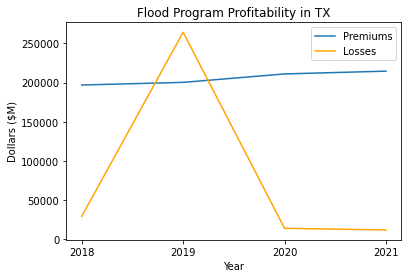

In [30]:
# Graph total TX premiums and Losses for 2018-2021

sns.lineplot(x=prem['Policy_Effective_Year'], y=prem['Policy_Insurance_Premium'], label='Premiums')
sns.lineplot(x=prem['Policy_Effective_Year'], y=prem['Total_Loss']/1000000, color='orange', label='Losses')

plt.title("Flood Program Profitability in TX")
plt.xlabel('Year')
plt.ylabel('Dollars ($M)')
plt.xticks([2018, 2019, 2020, 2021])

plt.legend()
plt.show()

In [31]:
# Close connection to database.

conn.close()